# GTC_03_model_training


This notebook handles the model definition, fine-tuning a pre-trained ResNet model, training on the EuroSAT dataset, evaluation, and saving the model.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## load the dataset

In [2]:
data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
    
)

data_path = "/kaggle/input/eurosat-dataset/EuroSAT"

data = data_generator.flow_from_directory(
    data_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    classes=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'] 

)


Found 27000 images belonging to 10 classes.


his cell is used for loading and preprocessing the dataset. An ImageDataGenerator is used for data augmentation and normalization. It also defines the path to the dataset and sets up the image flow from the directory.



## Train-test split 

In [3]:
train_data = data_generator.flow_from_directory(
    data_path,
    target_size=(64, 64),
    batch_size=8,
    class_mode='categorical',
    subset='training',
    classes=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

    

)


Found 21600 images belonging to 10 classes.


In [4]:
test_data = data_generator.flow_from_directory(
    data_path,
    target_size=(64, 64),
    batch_size=1,
    subset='validation',
    class_mode='categorical',
    classes=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


    
)


Found 5400 images belonging to 10 classes.


These two cells split the dataset into training and testing sets. train_data and test_data are created using the ImageDataGenerator with the subset parameter set to 'training' and 'validation' respectively.

## Building an ANN model 

In [5]:
ann = keras.Sequential([
        keras.layers.Flatten(input_shape=(64,64,3)),
        keras.layers.Dense(3000, activation='relu'),
        keras.layers.Dense(1000, activation='relu'),
        keras.layers.Dense(10, activation='softmax')    
    ])

ann.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

ann.fit(train_data,validation_data=test_data, epochs=5)

Epoch 1/5
2700/2700 [==============================] - 505s 187ms/step - loss: 1.7379 - accuracy: 0.3475 - val_loss: 1.5740 - val_accuracy: 0.4020
Epoch 2/5
2700/2700 [==============================] - 455s 169ms/step - loss: 1.5308 - accuracy: 0.4337 - val_loss: 1.4309 - val_accuracy: 0.4846
Epoch 3/5
2700/2700 [==============================] - 505s 187ms/step - loss: 1.4349 - accuracy: 0.4757 - val_loss: 1.4354 - val_accuracy: 0.4757
Epoch 4/5
2700/2700 [==============================] - 458s 170ms/step - loss: 1.3738 - accuracy: 0.4987 - val_loss: 1.2944 - val_accuracy: 0.5326
Epoch 5/5
2700/2700 [==============================] - 460s 170ms/step - loss: 1.3320 - accuracy: 0.5186 - val_loss: 1.4978 - val_accuracy: 0.4656


This cell builds and trains the Artificial Neural Network (ANN) model. The model consists of a Flatten layer and two Dense hidden layers with a ReLU activation function, and a final Dense output layer with a softmax activation. The model is compiled using the SGD optimizer and trained for 5 epochs.

In [6]:
ann.evaluate(test_data)


5400/5400 [==============================] - 97s 18ms/step - loss: 1.5009 - accuracy: 0.4628


[1.500859022140503, 0.4627777636051178]

This cell evaluates the performance of the trained ANN model on the test data.

## Confusion Matrix for ANN

In [7]:
from sklearn.metrics import confusion_matrix,classification_report

y_true = []
for i in range(test_data.samples // test_data.batch_size):
    _, batch_labels = test_data.next()
    y_true.extend(np.argmax(batch_labels, axis=-1))
    
# Generating predictions for test data
y_probab = ann.predict(test_data, steps=np.ceil(test_data.samples/test_data.batch_size))

#Generating predicted classes for test data
y_pred = np.argmax(y_probab, axis=-1)

#Generating confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Classification Report: \n", classification_report(y_true, y_pred))

5400/5400 [==============================] - 96s 18ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.57      0.61      0.59       600
           1       0.40      0.29      0.34       600
           2       0.34      0.56      0.42       600
           3       0.35      0.14      0.20       500
           4       0.91      0.50      0.64       500
           5       0.69      0.29      0.41       400
           6       0.48      0.33      0.39       500
           7       0.53      0.47      0.50       600
           8       0.40      0.59      0.47       500
           9       0.44      0.80      0.57       600

    accuracy                           0.47      5400
   macro avg       0.51      0.46      0.45      5400
weighted avg       0.50      0.47      0.46      5400



This cell calculates and prints the confusion matrix and classification report for the ANN model, providing a detailed breakdown of the model's performance for each class.

## plotting the matrix

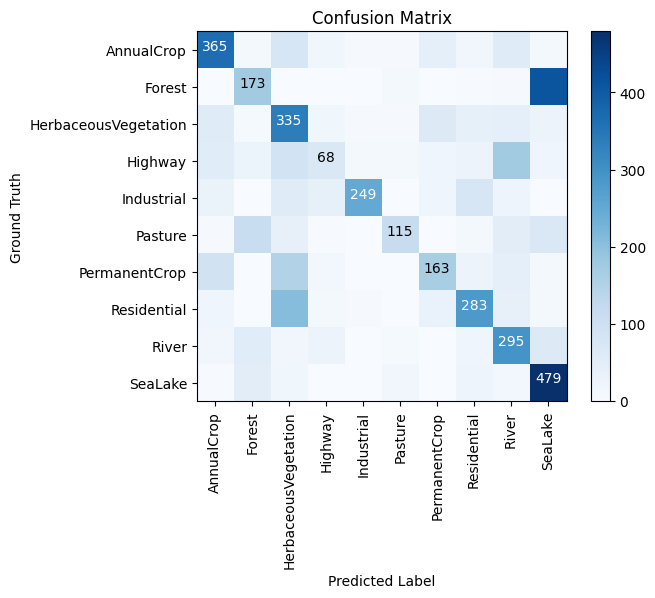

In [8]:
#plotting confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(data.class_indices))
plt.xticks(tick_marks, data.class_indices, rotation=90)
plt.yticks(tick_marks, data.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth')

# adding values in each cell
thresh = cm.max() / 2.
for i, j in zip(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

## Building a CNN model

In [9]:
CNN = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10,activation='softmax')
        
])

This cell builds and trains the Convolutional Neural Network (CNN) model. It includes convolutional layers (Conv2D), max-pooling layers (MaxPooling2D), and dense layers. The model is compiled with the Adam optimizer and trained for 10 epochs.

In [10]:
CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [11]:
CNN.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
2700/2700 [==============================] - 151s 56ms/step - loss: 1.4689 - accuracy: 0.4478 - val_loss: 1.0908 - val_accuracy: 0.5820
Epoch 2/10
2700/2700 [==============================] - 132s 49ms/step - loss: 0.9077 - accuracy: 0.6713 - val_loss: 0.7386 - val_accuracy: 0.7404
Epoch 3/10
2700/2700 [==============================] - 148s 55ms/step - loss: 0.7283 - accuracy: 0.7377 - val_loss: 0.7155 - val_accuracy: 0.7357
Epoch 4/10
2700/2700 [==============================] - 132s 49ms/step - loss: 0.6403 - accuracy: 0.7696 - val_loss: 0.6520 - val_accuracy: 0.7737
Epoch 5/10
2700/2700 [==============================] - 130s 48ms/step - loss: 0.5755 - accuracy: 0.7933 - val_loss: 0.6487 - val_accuracy: 0.7722
Epoch 6/10
2700/2700 [==============================] - 131s 48ms/step - loss: 0.5206 - accuracy: 0.8143 - val_loss: 0.6251 - val_accuracy: 0.7763
Epoch 7/10
2700/2700 [==============================] - 134s 50ms/step - loss: 0.4824 - accuracy: 0.8296 - val_loss: 0

In [12]:
CNN.evaluate(test_data)
 

5400/5400 [==============================] - 27s 5ms/step - loss: 0.5653 - accuracy: 0.8107


[0.5652816891670227, 0.8107407689094543]

This cell evaluates the performance of the trained CNN model on the test data. Which is 81% accracy, then we conclude that CNN works better than ANN on this data

## Confusion matrix for CNN

In [13]:
y_true = []
for i in range(test_data.samples // test_data.batch_size):
    _, batch_labels = test_data.next()
    y_true.extend(np.argmax(batch_labels, axis=-1))

# Generating predictions for test data
y_probab = CNN.predict(test_data, steps=np.ceil(test_data.samples/test_data.batch_size))

#Generating predicted classes for test data
y_pred = np.argmax(y_probab, axis=-1)

#Generating confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Classification Report: \n", classification_report(y_true, y_pred))

5400/5400 [==============================] - 25s 5ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       600
           1       0.91      0.94      0.92       600
           2       0.74      0.73      0.74       600
           3       0.63      0.66      0.64       500
           4       0.91      0.91      0.91       500
           5       0.69      0.85      0.76       400
           6       0.85      0.33      0.48       500
           7       0.91      0.96      0.93       600
           8       0.71      0.77      0.74       500
           9       0.92      0.98      0.95       600

    accuracy                           0.81      5400
   macro avg       0.81      0.80      0.79      5400
weighted avg       0.81      0.81      0.80      5400



## Plotting the matrix

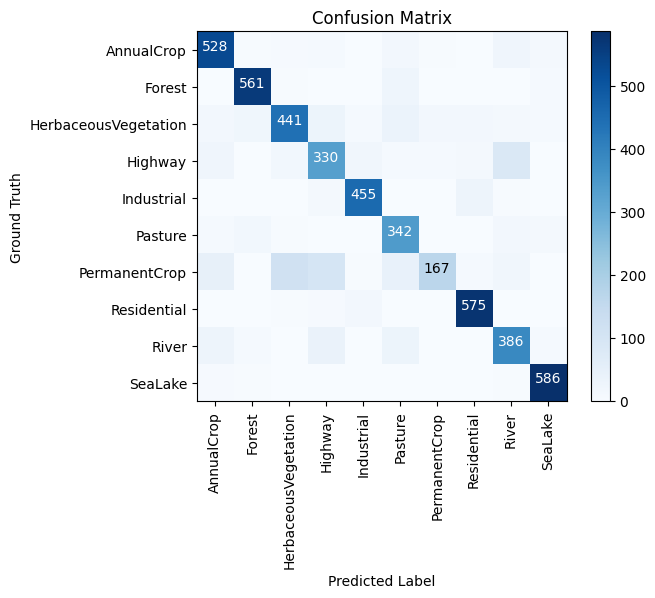

In [14]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(data.class_indices))
plt.xticks(tick_marks, data.class_indices, rotation=90)
plt.yticks(tick_marks, data.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth')

#adding values in each cell
thresh = cm.max() / 2.
for i, j in zip(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

#### RESULTS:With CNN, at the end 10 epochs, accuracy was at around 80.40% which is a significant improvement over ANN. CNN's are best for image classification and gives better accuracy. Also computation is much less compared to simple ANN as maxpooling reduces the image dimensions while still preserving the features.


In [4]:
### saving the model 

In [ ]:
cnn.save('eurosat_cnn_model') 

##### u can use the model from : 
from tensorflow import keras

loaded_model = keras.models.load_model('eurosat_cnn_model')
